## Start of the coding -- Installing of puppeteer


ÜBER UNS
Wer wir sind
Verantwortlich für die überregionale Versorgung und Übertragung im Höchstspannungsbereich sind in Deutschland die vier Übertragungsnetzbetreiber (ÜNB) 50Hertz, Amprion, TenneT und TransnetBW.
Mehr erfahren
Zahlen & Fakten
News
NUTZEN STATT ABREGELN / USE INSTEAD OF CURTAIL
01. August 2024
Nutzen statt Abregeln: Veröffentlichung von Vertragsunterlagen und Parametern
01. August 2024 - Bayreuth, Berlin, Dortmund, Stuttgart.
Die vier ÜNB haben heute Vertragsunterlagen, ÜNB-Parameter und FAQ zum Instrument "Nutzen statt Abregeln" (§ 13k EnWG) veröffentlicht. Diese Dokumente bieten umfassende Informationen für potenzielle Teilnehmer und Interessenten.
Zum Inhalt
SONSTIGE THEMEN / OTHER TOPICS
15. Juli 2024
Veröffentlichung der 1. Ergänzung zum Maßnahmenkatalog zum Netzwiederaufbauplan
15. Juli 2024 - Bayreuth, Berlin, Dortmund, Stuttgart.
Die erste Ergänzung zum Maßnahmenkatalog zum Netzwiederaufbauplan wurde durch die vier ÜNB fertiggestellt und tritt zum 1. August 202

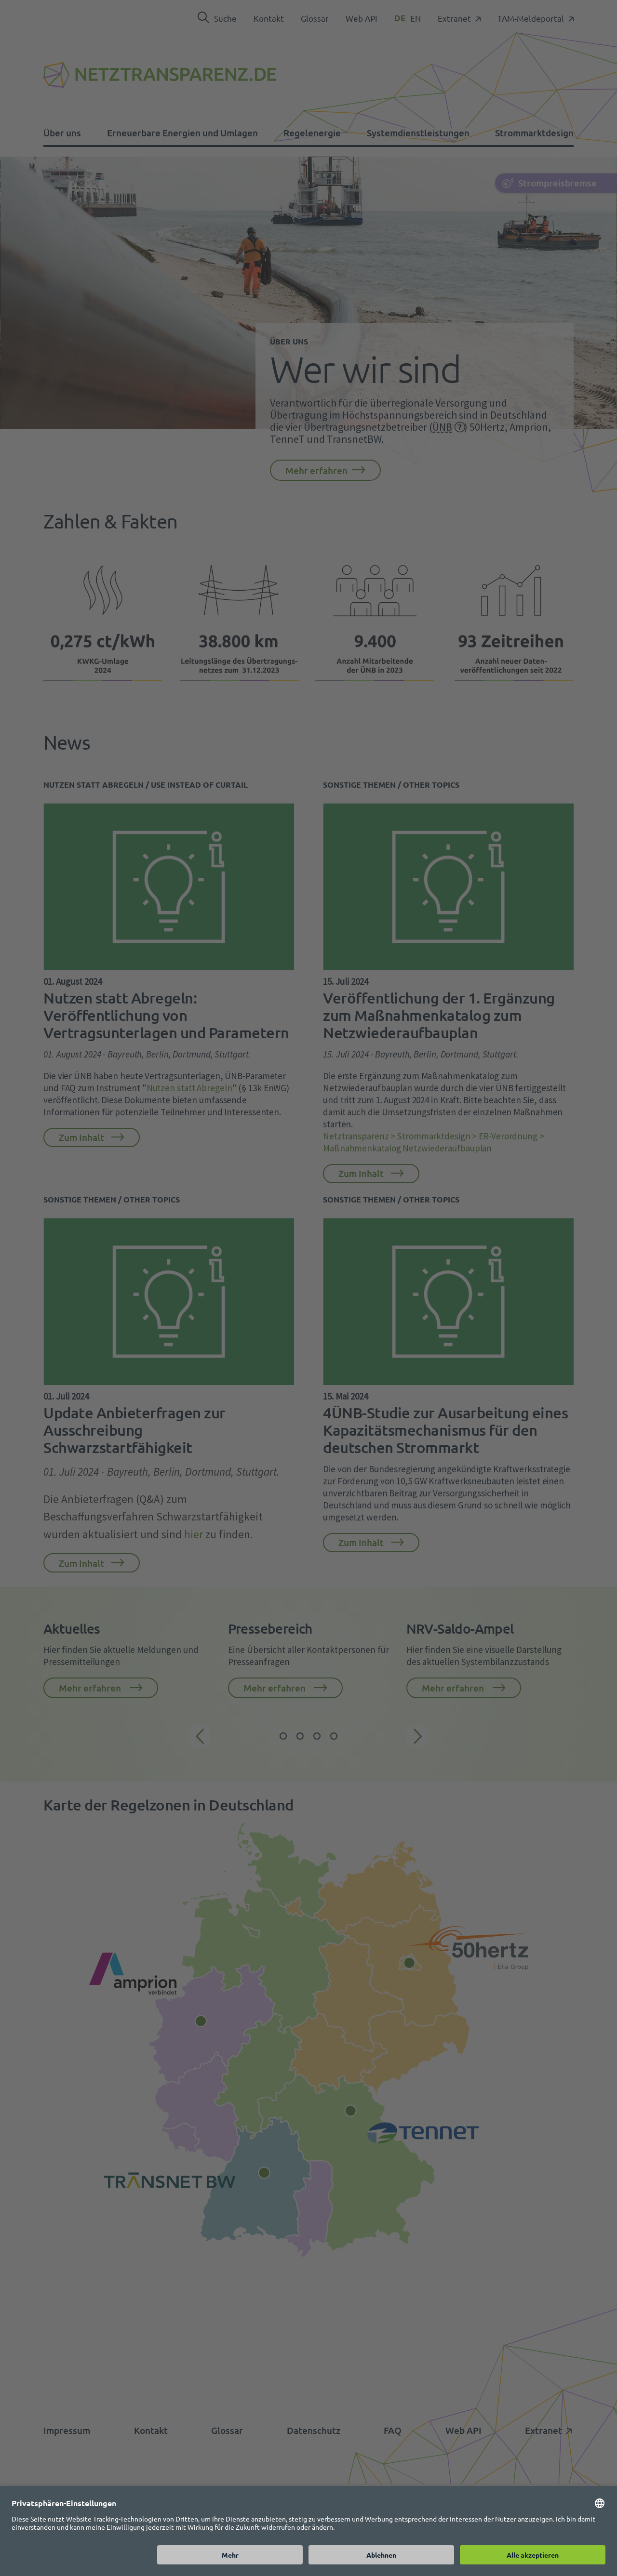

In [1]:
!pip install pyppeteer nest_asyncio

import asyncio
from pyppeteer import launch
import nest_asyncio
from IPython.display import Image, display

# Apply the nest_asyncio patch to allow nested event loops
nest_asyncio.apply()

async def scraper(url, block_resources=False, timeout=60000):
    try:
        # Launch the browser and create a new page
        browser = await launch(headless=True, args=['--no-sandbox', '--disable-gpu'])
        page = await browser.newPage()

        # Optionally block resources
        if block_resources:
            await page.setRequestInterception(True)
            page.on('request', lambda request: asyncio.ensure_future(
                request.continue_() if request.resourceType in ['document', 'script', 'xhr', 'fetch', 'stylesheet'] else request.abort()
            ))

        # Set the viewport and navigate to the URL
        await page.setViewport({"width": 1280, "height": 720})
        await page.goto(url, timeout=timeout)

        # Wait for the page to load and ensure everything is rendered
        await page.waitForSelector("body", {"timeout": 60000})
        await asyncio.sleep(15)  # Ensure all elements are loaded

        # Extract content from the page with flexible selectors
        try:
            content_text = await page.evaluate('''() => {
                let textContent = new Set();  // Use a set to avoid redundancy
                const mainContentSelectors = ["main", "article", "section", "div", "p"];

                mainContentSelectors.forEach(selector => {
                    const elements = document.querySelectorAll(selector);
                    elements.forEach(element => {
                        if (element && element.innerText) {
                            // Add unique non-empty lines to the set to avoid redundancy
                            element.innerText.split('\\n').forEach(line => {
                                if (line.trim()) {
                                    textContent.add(line.trim());
                                }
                            });
                        }
                    });
                });
                return Array.from(textContent).join("\\n");  // Convert set back to string
            }''')
        except Exception as e:
            print(f"Error extracting content: {e}")
            content_text = "No content could be extracted."

        print(content_text)

        # Take a screenshot
        screenshot_path = "full-page-screenshot.png"
        await page.screenshot(path=screenshot_path, fullPage=True)

        # Close the browser
        await browser.close()

        return screenshot_path

    except Exception as e:
        print(f"An error occurred: {e}")
        return None

# Define the URL you want to scrape
url = "https://www.netztransparenz.de/de-de/"

# Run the scraper function
screenshot_path = await scraper(url, block_resources=False, timeout=90000)

if screenshot_path:
    display(Image(screenshot_path))
else:
    print("Screenshot could not be taken.")


In [ ]:
import openpyxl
import pandas as pd
import asyncio
import requests
from io import BytesIO
from pyppeteer import launch
import nest_asyncio
from IPython.display import Image, display
from urllib.parse import urlparse

# Apply the nest_asyncio patch to allow nested event loops
nest_asyncio.apply()

async def scraper(url, block_resources=False, timeout=60000):
    try:
        # Launch the browser and create a new page
        browser = await launch(headless=True, args=['--no-sandbox', '--disable-gpu'])
        page = await browser.newPage()

        # Optionally block resources
        if block_resources:
            await page.setRequestInterception(True)
            page.on('request', lambda request: asyncio.ensure_future(
                request.continue_() if request.resourceType in ['document', 'script', 'xhr', 'fetch', 'stylesheet'] else request.abort()
            ))

        # Set the viewport and navigate to the URL
        await page.setViewport({"width": 1280, "height": 720})
        await page.goto(url, timeout=timeout)

        # Wait for the page to load and ensure everything is rendered
        await page.waitForSelector("body", {"timeout": 60000})
        await asyncio.sleep(15)  # Ensure all elements are loaded

        # Extract content from the page with flexible selectors
        try:
            content_text = await page.evaluate('''() => {
                let textContent = new Set();  // Use a set to avoid redundancy
                const mainContentSelectors = ["main", "article", "section", "div", "p"];

                mainContentSelectors.forEach(selector => {
                    const elements = document.querySelectorAll(selector);
                    elements.forEach(element => {
                        if (element && element.innerText) {
                            // Add unique non-empty lines to the set to avoid redundancy
                            element.innerText.split('\\n').forEach(line => {
                                if (line.trim()) {
                                    textContent.add(line.trim());
                                }
                            });
                        }
                    });
                });
                return Array.from(textContent).join("\\n");  // Convert set back to string
            }''')
        except Exception as e:
            print(f"Error extracting content: {e}")
            content_text = "No content could be extracted."

        print(content_text)

        # Take a screenshot
        #screenshot_path = f"{urlparse(url).netloc.replace('/', '_')}_screenshot.png"
        #await page.screenshot(path=screenshot_path, fullPage=True)

        # Close the browser
        await browser.close()

        #return screenshot_path

    except Exception as e:
        print(f"An error occurred: {e}")
        return None

def read_hyperlinked_urls(github_url):
    # Modify the URL to access the raw content
    raw_url = github_url.replace('github.com', 'raw.githubusercontent.com').replace('/blob/', '/')

    # Fetch the Excel file from GitHub
    response = requests.get(raw_url)
    response.raise_for_status()  # Ensure the request was successful

    # Load the Excel file using openpyxl
    wb = openpyxl.load_workbook(BytesIO(response.content))
    sheet = wb['Deutschland']

    urls = []
    for row in sheet.iter_rows(min_row=2, max_col=2, values_only=False):
        cell = row[1]  # Assuming URL is in the second column
        if cell.hyperlink:
            urls.append(cell.hyperlink.target)
        else:
            urls.append(cell.value)  # Fallback if no hyperlink is found, though it shouldn't happen

    return urls

# Define the GitHub URL to your Excel file
github_excel_url = "https://github.com/zubair9519/zubair9519/blob/main/Web%20Scrapping%20-%20Sample.xlsx"

# Extract the URLs from the Excel file with hyperlinks
urls = read_hyperlinked_urls(github_excel_url)

# Scrape each URL
for url in urls:
    print(f"Scraping {url}...")
    #screenshot_path = await scraper(url, block_resources=False, timeout=90000)
    #if screenshot_path:
    #    display(Image(screenshot_path))
    #else:
    #    print(f"Screenshot could not be taken for {url}.")


Scraping https://www.netztransparenz.de/de-de/...
Scraping https://www.pv-magazine.de/...
Scraping https://www.regelleistung.net/de-de/...
Scraping https://www.entsoe.eu/network_codes/eb/...
Scraping https://www.linkedin.com/in/lars-stephan/recent-activity/all/...
Scraping https://www.bmwk.de/Redaktion/DE/Artikel/Energie/Energiespeicher/stromspeicher-strategie.html...
Scraping https://www.bundesnetzagentur.de/DE/Home/home_node.html...
Scraping https://www.bves.de/...
Scraping https://www.bdew.de/...
Scraping https://www.bbc.com/...
Scraping https://edition.cnn.com/...


In [ ]:
import openpyxl
import pandas as pd
import asyncio
import requests
from io import BytesIO
from pyppeteer import launch
import nest_asyncio
from openpyxl import Workbook, load_workbook
from openpyxl.utils.dataframe import dataframe_to_rows
from urllib.parse import urlparse
import base64
import json
from datetime import datetime
from openpyxl.styles import Alignment

# Apply the nest_asyncio patch to allow nested event loops
nest_asyncio.apply()

async def scraper(url, block_resources=False, timeout=60000):
    try:
        # Launch the browser and create a new page
        browser = await launch(headless=True, args=['--no-sandbox', '--disable-gpu'])
        page = await browser.newPage()

        # Optionally block resources
        if block_resources:
            await page.setRequestInterception(True)
            page.on('request', lambda request: asyncio.ensure_future(
                request.continue_() if request.resourceType in ['document', 'script', 'xhr', 'fetch', 'stylesheet'] else request.abort()
            ))

        # Set the viewport and navigate to the URL
        await page.setViewport({"width": 1280, "height": 720})
        await page.goto(url, timeout=timeout)

        # Wait for the page to load and ensure everything is rendered
        await page.waitForSelector("body", {"timeout": 60000})
        await asyncio.sleep(15)  # Ensure all elements are loaded

        # Extract content from the page with flexible selectors
        try:
            content_text = await page.evaluate('''() => {
                let textContent = new Set();  // Use a set to avoid redundancy
                const mainContentSelectors = ["main", "article", "section", "div", "p"];

                mainContentSelectors.forEach(selector => {
                    const elements = document.querySelectorAll(selector);
                    elements.forEach(element => {
                        if (element && element.innerText) {
                            // Add unique non-empty lines to the set to avoid redundancy
                            element.innerText.split('\\n').forEach(line => {
                                if (line.trim()) {
                                    textContent.add(line.trim());
                                }
                            });
                        }
                    });
                });
                return Array.from(textContent).join("\\n");  // Convert set back to string
            }''')
        except Exception as e:
            print(f"Error extracting content: {e}")
            content_text = "No content could be extracted."

        # Close the browser
        await browser.close()

        return content_text

    except Exception as e:
        print(f"An error occurred: {e}")
        return None

def read_hyperlinked_urls(github_url):
    # Modify the URL to access the raw content
    raw_url = github_url.replace('github.com', 'raw.githubusercontent.com').replace('/blob/', '/')

    # Fetch the Excel file from GitHub
    response = requests.get(raw_url)
    response.raise_for_status()  # Ensure the request was successful

    # Load the Excel file using openpyxl
    wb = openpyxl.load_workbook(BytesIO(response.content))
    sheet = wb['Deutschland']

    urls = []
    website_names = []
    for row in sheet.iter_rows(min_row=2, max_col=2, values_only=False):
        website_names.append(row[0].value)
        cell = row[1]  # Assuming URL is in the second column
        if cell.hyperlink:
            urls.append(cell.hyperlink.target)
        else:
            urls.append(cell.value)  # Fallback if no hyperlink is found, though it shouldn't happen

    return website_names, urls

def fetch_existing_results(repo, path, branch, token):
    headers = {
        "Authorization": f"token {token}",
        "Content-Type": "application/json"
    }
    url = f"https://api.github.com/repos/{repo}/contents/{path}?ref={branch}"

    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        content = base64.b64decode(response.json()['content'])
        wb = load_workbook(BytesIO(content))
        sheet = wb.active
        data = sheet.values
        cols = next(data)
        df = pd.DataFrame(data, columns=cols)
        return df
    return None

def save_results_to_excel(website_names, urls, old_results, new_results, simulation_time, output_file='Scraping_Results.xlsx'):
    # If there are no old results, initialize the DataFrame
    if old_results is None:
        old_results = pd.DataFrame(columns=['Website Name', 'URL', 'Results', 'Latest_Results', 'Comparison', 'Last Simulation Time'])

    for i, (name, url, new_result) in enumerate(zip(website_names, urls, new_results)):
        if url in old_results['URL'].values:
            # If URL exists, update the Latest_Results and Comparison
            idx = old_results[old_results['URL'] == url].index[0]
            old_results.at[idx, 'Latest_Results'] = new_result
            if old_results.at[idx, 'Results'] == new_result:
                old_results.at[idx, 'Comparison'] = 'No change'
            else:
                old_results.at[idx, 'Comparison'] = 'There is a change'
            old_results.at[idx, 'Last Simulation Time'] = simulation_time
        else:
            # If URL does not exist, add new row
            new_row = pd.DataFrame([{
                'Website Name': name,
                'URL': url,
                'Results': new_result,
                'Latest_Results': new_result,
                'Comparison': 'New one',
                'Last Simulation Time': simulation_time
            }])
            old_results = pd.concat([old_results, new_row], ignore_index=True)

    # Create a new Excel workbook and add the DataFrame
    wb = Workbook()
    ws = wb.active
    ws.title = 'Scraping Results'

    # Write the DataFrame to the Excel sheet
    for row in dataframe_to_rows(old_results, index=False, header=True):
        ws.append(row)

    # Apply text wrapping to all cells
    for row in ws.iter_rows():
        for cell in row:
            cell.alignment = Alignment(wrap_text=True)

    # Save the workbook to a bytes object
    output = BytesIO()
    wb.save(output)
    return output.getvalue()

def upload_to_github(file_content, repo, path, message, branch, token):
    headers = {
        "Authorization": f"token {token}",
        "Content-Type": "application/json"
    }
    url = f"https://api.github.com/repos/{repo}/contents/{path}?ref={branch}"

    # Get the file content in base64
    content = base64.b64encode(file_content).decode("utf-8")

    # Check if the file exists
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        sha = response.json()['sha']
    else:
        sha = None

    # Create the data payload
    data = {
        "message": message,
        "content": content,
        "branch": branch,
    }
    if sha:
        data["sha"] = sha

    # Make the PUT request to create/update the file
    result = requests.put(url, headers=headers, data=json.dumps(data))
    if result.status_code in [200, 201]:
        print(f"File '{path}' successfully uploaded to GitHub.")
    else:
        print(f"Failed to upload file to GitHub. Status code: {result.status_code}")
        print(result.text)

# Define the GitHub URL to your Excel file
github_excel_url = "https://github.com/zubair9519/zubair9519/blob/main/Web%20Scrapping%20-%20Sample.xlsx"

# Define your GitHub repository, file path, commit message, and branch
repo = "zubair9519/zubair9519"  # Your GitHub repository
path = "Scraping_Results.xlsx"  # Path in the repository where you want to save the file
message = "Updated scraping results"  # Commit message
branch = "main"  # Branch to commit to
token = ""  # Your GitHub Personal Access Token

# Extract the URLs and website names from the Excel file with hyperlinks
website_names, urls = read_hyperlinked_urls(github_excel_url)

# Fetch existing results from GitHub (if available)
old_results = fetch_existing_results(repo, path, branch, token)

# Initialize an empty list to store the results
new_results = []

# Scrape each URL and store the result
for url in urls:
    print(f"Scraping {url}...")
    content = await scraper(url, block_resources=False, timeout=90000)
    new_results.append(content)

# Get the current simulation time
simulation_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# Save the results to a new Excel file
file_content = save_results_to_excel(website_names, urls, old_results, new_results, simulation_time)

# Upload the Excel file to GitHub
upload_to_github(file_content, repo, path, message, branch, token)


Scraping https://www.netztransparenz.de/de-de/...
Scraping https://www.pv-magazine.de/...
Scraping https://www.regelleistung.net/de-de/...
Scraping https://www.entsoe.eu/network_codes/eb/...
Scraping https://www.linkedin.com/in/lars-stephan/recent-activity/all/...
Scraping https://www.bmwk.de/Redaktion/DE/Artikel/Energie/Energiespeicher/stromspeicher-strategie.html...
Scraping https://www.bundesnetzagentur.de/DE/Home/home_node.html...
Scraping https://www.bves.de/...
Scraping https://www.bdew.de/...
Scraping https://www.bbc.com/...
Scraping https://edition.cnn.com/...
File 'Scraping_Results.xlsx' successfully uploaded to GitHub.


In [ ]:
import pandas as pd
import requests
from io import BytesIO
from openpyxl import load_workbook
import difflib

def fetch_excel_from_github(repo, path, branch, token):
    headers = {
        "Authorization": f"token {token}",
        "Content-Type": "application/json"
    }
    url = f"https://api.github.com/repos/{repo}/contents/{path}?ref={branch}"

    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        content = base64.b64decode(response.json()['content'])
        return pd.read_excel(BytesIO(content))
    else:
        print("Failed to fetch the file from GitHub.")
        return None

def get_differences(old, new):
    # Ensure both are strings to avoid attribute errors
    old = str(old) if old is not None else ""
    new = str(new) if new is not None else ""




    # + for addition in new edition, - for subtraction
    differ = difflib.Differ()
    diff = list(differ.compare(old.splitlines(), new.splitlines()))
    changes = [line for line in diff if line.startswith('+ ') or line.startswith('- ')]
    return changes

def compare_columns(df):
    differences = []
    for index, row in df.iterrows():
        if row['Results'] != row['Latest_Results']:
            changes = get_differences(row['Results'], row['Latest_Results'])
            if changes:
                differences.append({
                    "Website Name": row['Website Name'],
                    "URL": row['URL'],
                    "Changes": changes
                })
    return differences

# Define your GitHub repository, file path, branch, and token
repo = "zubair9519/zubair9519"  # Your GitHub repository
path = "Scraping_Results.xlsx"  # Path in the repository where you want to save the file
branch = "main"  # Branch to commit to
token = ""  # Your GitHub Personal Access Token

# Fetch the Excel file from GitHub
df = fetch_excel_from_github(repo, path, branch, token)



# Compare the columns and print only the changes
if df is not None:
    differences = compare_columns(df)
    if differences:
        print("Differences between 'Results' and 'Latest_Results':")
        for diff in differences:
            print(f"Website Name: {diff['Website Name']}")
            print(f"URL: {diff['URL']}")
            print("Changes:")
            for change in diff['Changes']:
                print(change)
            print("-----")
    else:
        print("No differences found between 'Results' and 'Latest_Results'.")
else:
    print("Could not load the Excel file.")


Differences between 'Results' and 'Latest_Results':
Website Name: Bundesnetzagentur
URL: https://www.bundesnetzagentur.de/DE/Home/home_node.html
Changes:
+ Wasserstoff
+ Bundesnetzagentur erhält den Antrag für das Wasserstoff-Kernnetz
- 4 / 5
+ 5 / 5
- Wasserstoff      Bundesnetzagentur erhält den Antrag für das Wasserstoff-Kernnetz
- Wasserstoff
- Bundesnetzagentur erhält den Antrag für das Wasserstoff-Kernnetz
-----
Website Name: BDEW
URL: https://www.bdew.de/
Changes:
- Alles Wasser Volt
- Deine Zukunft für eine nachhaltige Zukunft: Bewirb Dich jetzt in der Energie- und Wasserwirtschaft
+ An­bie­ter­lis­te Dienst­leis­ter Re­dis­patch 2.0
+ Auf der Website des BDEW finden Sie eine offene Liste mit Unternehmen, die Dienstleistungen für Anlagenbetreiber im Rahmen des neuen Redispatchregimes erbringen.
+ ZUR ANBIETERLISTE
- An­bie­ter­lis­te Dienst­leis­ter Re­dis­patch 2.0
- Auf der Website des BDEW finden Sie eine offene Liste mit Unternehmen, die Dienstleistungen für Anlagenbetreibe

## Final code


In [4]:
import openpyxl
import pandas as pd
import asyncio
import requests
from io import BytesIO
from pyppeteer import launch
import nest_asyncio
from openpyxl import Workbook, load_workbook
from openpyxl.utils.dataframe import dataframe_to_rows
from urllib.parse import urlparse
import base64
import json
from datetime import datetime
from openpyxl.styles import Alignment
import difflib

# Apply the nest_asyncio patch to allow nested event loops
nest_asyncio.apply()

async def scraper(url, block_resources=False, timeout=60000):
    try:
        browser = await launch(headless=True, args=['--no-sandbox', '--disable-gpu'])
        page = await browser.newPage()

        if block_resources:
            await page.setRequestInterception(True)
            page.on('request', lambda request: asyncio.ensure_future(
                request.continue_() if request.resourceType in ['document', 'script', 'xhr', 'fetch', 'stylesheet'] else request.abort()
            ))

        await page.setViewport({"width": 1280, "height": 720})
        await page.goto(url, timeout=timeout)
        await page.waitForSelector("body", {"timeout": 60000})
        await asyncio.sleep(15)  # Ensure all elements are loaded

        try:
            content_text = await page.evaluate('''() => {
                let textContent = new Set();
                const mainContentSelectors = ["main", "article", "section", "div", "p"];

                mainContentSelectors.forEach(selector => {
                    const elements = document.querySelectorAll(selector);
                    elements.forEach(element => {
                        if (element && element.innerText) {
                            element.innerText.split('\\n').forEach(line => {
                                if (line.trim()) {
                                    textContent.add(line.trim());
                                }
                            });
                        }
                    });
                });
                return Array.from(textContent).join("\\n");
            }''')
        except Exception as e:
            print(f"Error extracting content: {e}")
            content_text = "No content could be extracted."

        await browser.close()

        return content_text

    except Exception as e:
        print(f"An error occurred: {e}")
        return None

def read_hyperlinked_urls(github_url):
    raw_url = github_url.replace('github.com', 'raw.githubusercontent.com').replace('/blob/', '/')

    response = requests.get(raw_url)
    response.raise_for_status()

    wb = openpyxl.load_workbook(BytesIO(response.content))
    sheet = wb['Deutschland']

    urls = []
    website_names = []
    for row in sheet.iter_rows(min_row=2, max_col=2, values_only=False):
        website_names.append(row[0].value)
        cell = row[1]
        if cell.hyperlink:
            urls.append(cell.hyperlink.target)
        else:
            urls.append(cell.value)

    return website_names, urls

def fetch_existing_results(repo, path, branch, token):
    headers = {
        "Authorization": f"token {token}",
        "Content-Type": "application/json"
    }
    url = f"https://api.github.com/repos/{repo}/contents/{path}?ref={branch}"

    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        content = base64.b64decode(response.json()['content'])
        wb = load_workbook(BytesIO(content))
        sheet = wb.active
        data = sheet.values
        cols = next(data)
        df = pd.DataFrame(data, columns=cols)
        return df
    return None

def get_differences(old, new):
    old = str(old) if old is not None else ""
    new = str(new) if new is not None else ""

    differ = difflib.Differ()
    diff = list(differ.compare(old.splitlines(), new.splitlines()))
    changes = [line for line in diff if line.startswith('+ ') or line.startswith('- ')]
    return "\n".join(changes) if changes else None

def save_results_to_excel(website_names, urls, old_results, new_results, simulation_time, output_file='Scraping_Results.xlsx'):
    if old_results is None:
        old_results = pd.DataFrame(columns=['Website Name', 'URL', 'Results', 'Latest_Results', 'Comparison', 'Last Simulation Time', 'Differences'])

    for i, (name, url, new_result) in enumerate(zip(website_names, urls, new_results)):
        if url in old_results['URL'].values:
            idx = old_results[old_results['URL'] == url].index[0]
            old_results.at[idx, 'Latest_Results'] = new_result
            if old_results.at[idx, 'Results'] == new_result:
                old_results.at[idx, 'Comparison'] = 'No change'
                old_results.at[idx, 'Differences'] = None
            else:
                old_results.at[idx, 'Comparison'] = 'There is a change'
                old_results.at[idx, 'Differences'] = get_differences(old_results.at[idx, 'Results'], new_result)
            old_results.at[idx, 'Last Simulation Time'] = simulation_time
        else:
            new_row = pd.DataFrame([{
                'Website Name': name,
                'URL': url,
                'Results': new_result,
                'Latest_Results': new_result,
                'Comparison': 'New one',
                'Last Simulation Time': simulation_time,
                'Differences': None
            }])
            old_results = pd.concat([old_results, new_row], ignore_index=True)

    wb = Workbook()
    ws = wb.active
    ws.title = 'Scraping Results'

    for row in dataframe_to_rows(old_results, index=False, header=True):
        ws.append(row)

    for row in ws.iter_rows():
        for cell in row:
            cell.alignment = Alignment(wrap_text=True)

    output = BytesIO()
    wb.save(output)
    return output.getvalue()

def upload_to_github(file_content, repo, path, message, branch, token):
    headers = {
        "Authorization": f"token {token}",
        "Content-Type": "application/json"
    }
    url = f"https://api.github.com/repos/{repo}/contents/{path}?ref={branch}"

    content = base64.b64encode(file_content).decode("utf-8")

    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        sha = response.json()['sha']
    else:
        sha = None

    data = {
        "message": message,
        "content": content,
        "branch": branch,
    }
    if sha:
        data["sha"] = sha

    result = requests.put(url, headers=headers, data=json.dumps(data))
    if result.status_code in [200, 201]:
        print(f"File '{path}' successfully uploaded to GitHub.")
    else:
        print(f"Failed to upload file to GitHub. Status code: {result.status_code}")
        print(result.text)

# Define the GitHub URL to your Excel file
github_excel_url = "https://github.com/zubair9519/zubair9519/blob/main/Web%20Scrapping.xlsx"

# Define your GitHub repository, file path, commit message, and branch
repo = "zubair9519/zubair9519"
path = "Scraping_Results.xlsx"
message = "Updated scraping results"
branch = "main"
token = "   "  # Replace with your actual GitHub token

# Extract the URLs and website names from the Excel file with hyperlinks
website_names, urls = read_hyperlinked_urls(github_excel_url)

# Fetch existing results from GitHub (if available)
old_results = fetch_existing_results(repo, path, branch, token)

# Initialize an empty list to store the results
new_results = []

# Scrape each URL and store the result
for url in urls:
    print(f"Scraping {url}...")
    content = await scraper(url, block_resources=False, timeout=90000)
    new_results.append(content)

# Get the current simulation time
simulation_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# Save the results to a new Excel file
file_content = save_results_to_excel(website_names, urls, old_results, new_results, simulation_time)

# Upload the Excel file to GitHub
upload_to_github(file_content, repo, path, message, branch, token)


Scraping https://www.netztransparenz.de/de-de/...
Scraping https://www.netztransparenz.de/de-de/Systemdienstleistungen/Betriebsfuehrung...
Scraping https://www.netztransparenz.de/de-de/Systemdienstleistungen/Betriebsfuehrung/Redispatch...
Scraping https://www.netztransparenz.de/de-de/Systemdienstleistungen/Betriebsfuehrung/Kapazit%C3%A4tsreserve...
Scraping https://www.netztransparenz.de/de-de/Systemdienstleistungen/Betriebsfuehrung/Nutzen-statt-Abregeln...
Scraping https://www.netztransparenz.de/de-de/Systemdienstleistungen/Spannungshaltung/Blindleistung...
Scraping https://www.netztransparenz.de/de-de/Systemdienstleistungen/Versorgungswiederaufbau/Marktgest%C3%BCtzte-Beschaffung-von-Schwarzstartf%C3%A4higkeit...
Scraping https://www.netztransparenz.de/de-de/Strommarktdesign/4%C3%9CNB-Studie-zur-Ausarbeitung-eines-Kapazit%C3%A4tsmechanismus-f%C3%BCr-den-deutschen-Strommarkt...
Scraping https://www.netztransparenz.de/de-de/Erneuerbare-Energien-und-Umlagen/EEG/EEG-Finanzierung...
Scrapi

In [ ]:
import pandas as pd
import requests
from io import BytesIO

# Define the GitHub URL to your Excel file
github_excel_url = "https://github.com/zubair9519/zubair9519/blob/main/Web%20Scrapping%20-%20Sample.xlsx"

def load_excel_from_github(github_url):
    # Modify the URL to access the raw content
    raw_url = github_url.replace('github.com', 'raw.githubusercontent.com').replace('/blob/', '/')

    # Fetch the Excel file from GitHub
    response = requests.get(raw_url)
    response.raise_for_status()  # Ensure the request was successful

    # Load the Excel file into a Pandas ExcelFile object
    excel_file = pd.ExcelFile(BytesIO(response.content))

    return excel_file

# Load the Excel file from GitHub
excel_file = load_excel_from_github(github_excel_url)

# Print the sheet names
print("Sheet names in the Excel file:", excel_file.sheet_names)

# Loop through each sheet and print its content
for sheet_name in excel_file.sheet_names:
    print(f"\nContent of sheet '{sheet_name}':")
    df = pd.read_excel(excel_file, sheet_name=sheet_name)
    print(df)


Sheet names in the Excel file: ['Deutschland']

Content of sheet 'Deutschland':
          Website Name                                                URL
0      Netztransparenz                             Netztransparenz > Home
1  PV Magazine Germany  pv magazine Deutschland – Photovoltaik Märkte ...
2        Regelleistung                     Startseite (regelleistung.net)
3               ENTSOE                  Electricity Balancing (entsoe.eu)
4             LinkedIN             (9) Activity | Lars Stephan | LinkedIn
5                 BMWK  BMWK - Stromspeicher-Strategie des BMWK vorgelegt
6    Bundesnetzagentur                     Bundesnetzagentur - Startseite
7                 BVES                                  Startseite - BVES
8                 BDEW  BDEW Bundesverband der Energie- und Wasserwirt...


In [1]:
!pip install pyppeteer nest_asyncio


import openpyxl
import pandas as pd
import asyncio
import requests
from io import BytesIO
from pyppeteer import launch
import nest_asyncio
from openpyxl import Workbook, load_workbook
from openpyxl.utils.dataframe import dataframe_to_rows
from urllib.parse import urlparse
import base64
import json
from datetime import datetime
from openpyxl.styles import Alignment
import difflib

# Apply the nest_asyncio patch to allow nested event loops
nest_asyncio.apply()

async def scraper(url, block_resources=False, timeout=60000):
    try:
        browser = await launch(headless=True, args=['--no-sandbox', '--disable-gpu'])
        page = await browser.newPage()

        if block_resources:
            await page.setRequestInterception(True)
            page.on('request', lambda request: asyncio.ensure_future(
                request.continue_() if request.resourceType in ['document', 'script', 'xhr', 'fetch', 'stylesheet'] else request.abort()
            ))

        await page.setViewport({"width": 1280, "height": 720})
        await page.goto(url, timeout=timeout)
        await page.waitForSelector("body", {"timeout": 60000})
        await asyncio.sleep(15)  # Ensure all elements are loaded

        try:
            content_text = await page.evaluate('''() => {
                let textContent = new Set();
                const mainContentSelectors = ["main", "article", "section", "div", "p"];

                mainContentSelectors.forEach(selector => {
                    const elements = document.querySelectorAll(selector);
                    elements.forEach(element => {
                        if (element && element.innerText) {
                            element.innerText.split('\\n').forEach(line => {
                                if (line.trim()) {
                                    textContent.add(line.trim());
                                }
                            });
                        }
                    });
                });
                return Array.from(textContent).join("\\n");
            }''')
        except Exception as e:
            print(f"Error extracting content: {e}")
            content_text = "No content could be extracted."

        await browser.close()

        return content_text

    except Exception as e:
        print(f"An error occurred: {e}")
        return None

def read_hyperlinked_urls(github_url):
    raw_url = github_url.replace('github.com', 'raw.githubusercontent.com').replace('/blob/', '/')

    response = requests.get(raw_url)
    response.raise_for_status()

    wb = openpyxl.load_workbook(BytesIO(response.content))
    sheet = wb['Deutschland']

    urls = []
    website_names = []
    for row in sheet.iter_rows(min_row=2, max_col=2, values_only=False):
        website_names.append(row[0].value)
        cell = row[1]
        if cell.hyperlink:
            urls.append(cell.hyperlink.target)
        else:
            urls.append(cell.value)

    return website_names, urls

def fetch_existing_results(repo, path, branch, token):
    headers = {
        "Authorization": f"token {token}",
        "Content-Type": "application/json"
    }
    url = f"https://api.github.com/repos/{repo}/contents/{path}?ref={branch}"

    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        content = base64.b64decode(response.json()['content'])
        wb = load_workbook(BytesIO(content))
        sheet = wb.active
        data = sheet.values
        cols = next(data)
        df = pd.DataFrame(data, columns=cols)
        return df
    return None

def prepare_existing_results(df):
    """Move 'Latest_Results' column to 'Results' column."""
    if df is not None and 'Latest_Results' in df.columns and 'Results' in df.columns:
        df['Results'] = df['Latest_Results']
        df['Latest_Results'] = None
    return df

def get_differences(old, new):
    old = str(old) if old is not None else ""
    new = str(new) if new is not None else ""

    differ = difflib.Differ()
    diff = list(differ.compare(old.splitlines(), new.splitlines()))
    changes = [line for line in diff if line.startswith('+ ') or line.startswith('- ')]
    return "\n".join(changes) if changes else None

def save_results_to_excel(website_names, urls, old_results, new_results, simulation_time, output_file='Scraping_Results.xlsx'):
    if old_results is None:
        old_results = pd.DataFrame(columns=['Website Name', 'URL', 'Results', 'Latest_Results', 'Comparison', 'Last Simulation Time', 'Differences'])

    for i, (name, url, new_result) in enumerate(zip(website_names, urls, new_results)):
        if url in old_results['URL'].values:
            idx = old_results[old_results['URL'] == url].index[0]
            old_results.at[idx, 'Latest_Results'] = new_result
            if old_results.at[idx, 'Results'] == new_result:
                old_results.at[idx, 'Comparison'] = 'No change'
                old_results.at[idx, 'Differences'] = None
            else:
                old_results.at[idx, 'Comparison'] = 'There is a change'
                old_results.at[idx, 'Differences'] = get_differences(old_results.at[idx, 'Results'], new_result)
            old_results.at[idx, 'Last Simulation Time'] = simulation_time
        else:
            new_row = pd.DataFrame([{
                'Website Name': name,
                'URL': url,
                'Results': new_result,
                'Latest_Results': new_result,
                'Comparison': 'New one',
                'Last Simulation Time': simulation_time,
                'Differences': None
            }])
            old_results = pd.concat([old_results, new_row], ignore_index=True)

    wb = Workbook()
    ws = wb.active
    ws.title = 'Scraping Results'

    for row in dataframe_to_rows(old_results, index=False, header=True):
        ws.append(row)

    for row in ws.iter_rows():
        for cell in row:
            cell.alignment = Alignment(wrap_text=True)

    output = BytesIO()
    wb.save(output)
    return output.getvalue()

def upload_to_github(file_content, repo, path, message, branch, token):
    headers = {
        "Authorization": f"token {token}",
        "Content-Type": "application/json"
    }
    url = f"https://api.github.com/repos/{repo}/contents/{path}?ref={branch}"

    content = base64.b64encode(file_content).decode("utf-8")

    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        sha = response.json()['sha']
    else:
        sha = None

    data = {
        "message": message,
        "content": content,
        "branch": branch,
    }
    if sha:
        data["sha"] = sha

    result = requests.put(url, headers=headers, data=json.dumps(data))
    if result.status_code in [200, 201]:
        print(f"File '{path}' successfully uploaded to GitHub.")
    else:
        print(f"Failed to upload file to GitHub. Status code: {result.status_code}")
        print(result.text)

# Define the GitHub URL to your Excel file
github_excel_url = "https://github.com/zubair9519/zubair9519/blob/main/Web%20Scrapping.xlsx"

# Define your GitHub repository, file path, commit message, and branch
repo = "zubair9519/zubair9519"
path = "Scraping_Results.xlsx"
message = "Updated scraping results"
branch = "main"
token = "  "  # Replace with your actual GitHub token

# Extract the URLs and website names from the Excel file with hyperlinks
website_names, urls = read_hyperlinked_urls(github_excel_url)

# Fetch existing results from GitHub (if available)
old_results = fetch_existing_results(repo, path, branch, token)

# Prepare existing results by moving 'Latest_Results' to 'Results'
old_results = prepare_existing_results(old_results)

# Initialize an empty list to store the results
new_results = []

# Scrape each URL and store the result
for url in urls:
    print(f"Scraping {url}...")
    content = await scraper(url, block_resources=False, timeout=90000)
    new_results.append(content)

# Get the current simulation time
simulation_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# Save the results to a new Excel file
file_content = save_results_to_excel(website_names, urls, old_results, new_results, simulation_time)

# Upload the Excel file to GitHub
upload_to_github(file_content, repo, path, message, branch, token)


Scraping https://www.netztransparenz.de/de-de/...
Scraping https://www.netztransparenz.de/de-de/Systemdienstleistungen/Betriebsfuehrung...
Scraping https://www.netztransparenz.de/de-de/Systemdienstleistungen/Betriebsfuehrung/Redispatch...
Scraping https://www.netztransparenz.de/de-de/Systemdienstleistungen/Betriebsfuehrung/Kapazit%C3%A4tsreserve...
Scraping https://www.netztransparenz.de/de-de/Systemdienstleistungen/Betriebsfuehrung/Nutzen-statt-Abregeln...
Scraping https://www.netztransparenz.de/de-de/Systemdienstleistungen/Spannungshaltung/Blindleistung...
Scraping https://www.netztransparenz.de/de-de/Systemdienstleistungen/Versorgungswiederaufbau/Marktgest%C3%BCtzte-Beschaffung-von-Schwarzstartf%C3%A4higkeit...
Scraping https://www.netztransparenz.de/de-de/Strommarktdesign/4%C3%9CNB-Studie-zur-Ausarbeitung-eines-Kapazit%C3%A4tsmechanismus-f%C3%BCr-den-deutschen-Strommarkt...
Scraping https://www.netztransparenz.de/de-de/Erneuerbare-Energien-und-Umlagen/EEG/EEG-Finanzierung...
Scrapi